In this post I'll look at a classic example of a convex variational problem: computing [*minimal surfaces*](https://en.wikipedia.org/wiki/Minimal_surface).
The minimal surface problem has a simple physical interpretation in terms of soap films.
Suppose you have a wire loop and you stretch a film of soap over it; what shape does the film take?
The available energy that the film has to do mechanical work is proportional to the product of the surface tension and the area of the film.
When the film is in equilibrium, it will minimize the energy, so it will find the surface of least area that stretches over the hoop.
This shape is called a minimal surface.

Here we'll look at a geometrically simpler case where the surface can be described as the graph of a function defined on some footprint domain $\Omega$ that lives in the plane.
We'll describe the position of the hoop as a function $g$ that maps the boundary $\partial\Omega$ to the reals, and the surface as a function $u$ on $\Omega$.
The surface area of the graph of $u$ is the quantity

$$J(u) = \int_\Omega\sqrt{1 + |\nabla u|^2}\,dx.$$

So, our goal is to minimize the objective functional $J$ among all functions $u$ such that $u|_{\partial\Omega} = g$.
This is a classic example in variational calculus, which I'll assume you're familiar with.
If you haven't encountered this topic before, I learned about it from [Weinstock's book](https://books.google.com/books/about/Calculus_of_Variations.html?id=6wSVuWH1PrsC).

The weak form of the Euler-Lagrange equation for $J$ is

$$\int_\Omega\frac{\nabla u\cdot\nabla v}{\sqrt{1 + |\nabla u|^2}}dx = 0$$

for all $v$ that vanish on the boundary.
This PDE is just a specific way of stating the general condition that, for $u$ to be an extremum of $J$, its directional derivative along all perturbations $v$ must be 0:

$$\langle dJ(u), v\rangle = 0.$$

We can go a little bit further and calculate the second derivative of $J$ too:

$$\langle d^2J(u)\cdot v, w\rangle = \int_\Omega\frac{I - \frac{\nabla u\cdot \nabla u^*}{1 + |\nabla u|^2}}{\sqrt{1 + |\nabla u|^2}}\nabla v\cdot \nabla w\, dx,$$

Deriving this equation takes a bit of leg work, but the important part is that it looks like a symmetric, positive-definite elliptic operator, only the conductivity tensor depends on the gradient of $u$.
Since the second derivative of $J$ is positive-definite, the minimization problem is convex and thus has a unique solution.

There are many approaches you could take to solving the minimal surface equation.
I'll examine some here using the finite element modeling package [Firedrake](https://www.firedrakeproject.org).
If you're unfamiliar with Firedrake or FEniCS, their main selling point is that, rather than write code to fill matrices and vectors yourself, these packages use an embedded domain-specific language to describe the weak form of the PDE.
The library then generates efficient C code on the spot to fill these matrices and vectors.
Having done all this by hand for several years I can tell you this is a big improvement!

In [1]:
import firedrake

To keep things simple, we'll use the unit square as our spatial domain, and we'll use piecewise quadratic finite elements.

In [2]:
mesh = firedrake.UnitSquareMesh(100, 100, quadrilateral=True)
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2)

I'll use a test case from some [course notes](http://www-users.math.umn.edu/~arnold/8445-8446.17-18/) from a class that Douglas Arnold teaches on finite element methods.
The boundary curve is

$$g = ax\cdot\sin\left(\frac{5}{2}\pi y\right).$$

In the notes, Arnold uses $a = 1/5$.
When the numerical range of $g$ is small relative to the diameter of the domain, the minimal surface equation linearizes to the Laplace equation.
I want to instead look at the more nonlinear case of $a > 1$, which will stress the nonlinear solver a good deal more.

In [3]:
x, y = firedrake.SpatialCoordinate(mesh)

from numpy import pi as π
from firedrake import sin
a = firedrake.Constant(3/2)
g = a * x * sin(5 * π * y / 2)

A picture is worth a thousand words of course.

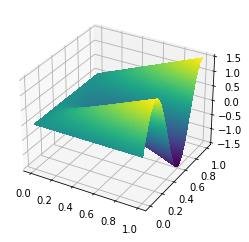

In [4]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
firedrake.trisurf(firedrake.interpolate(g, Q), axes=axes);

Here we'll create the proposed solution $u$, define the objective functional, and try to find the minimizer naively using Firedrake's built-in solver.
With the value for $a$ that I chose, the solver won't converge using its default settings.

In [5]:
u = firedrake.interpolate(g, Q)
bc = firedrake.DirichletBC(Q, g, 'on_boundary')

from firedrake import sqrt, inner, grad, dx
J = sqrt(1 + inner(grad(u), grad(u))) * dx
F = firedrake.derivative(J, u)

try:
    firedrake.solve(F == 0, u, bc)
except firedrake.ConvergenceError:
    print('Woops, nonlinear solver failed to converge!')

Woops, nonlinear solver failed to converge!


We could tweak these settings to make the solver converge, but instead let's try and dive deeper into what does and doesn't make for a good nonlinear solver.

#### Picard's method

This method is predicated on the idea that many nonlinear PDEs look like a linear problem with coefficients that depend on the solution.
If you freeze those coefficients at the current guess for the solution, you get something that's fairly easy to solve and hopefully convergent.
Suppose we've got a guess $u_n$ for the solution of the minimal surface equation.
The Picard method would give us a next guess $u_{n + 1}$ that solves the linear PDE

$$\int_\Omega\frac{\nabla u_{n + 1}\cdot\nabla v}{\sqrt{1 + |\nabla u_n|^2}}dx = 0$$

for all $v$ that vanish on the boundary.
This method is easy to implement if you know the functional form of the problem you're solving.
Let's see how fast this decreases the area.

In [6]:
u.interpolate(g)
u_n = u.copy(deepcopy=True)
v = firedrake.TestFunction(Q)

G = inner(grad(u), grad(v)) / sqrt(1 + inner(grad(u_n), grad(u_n))) * dx

import numpy as np
num_iterations = 24
Js = np.zeros(num_iterations)
Js[0] = firedrake.assemble(J)
for step in range(1, num_iterations):
    firedrake.solve(G == 0, u, bc)
    u_n.assign(u)
    Js[step] = firedrake.assemble(J)

The method converges in the eyeball norm in about 6 iterations.

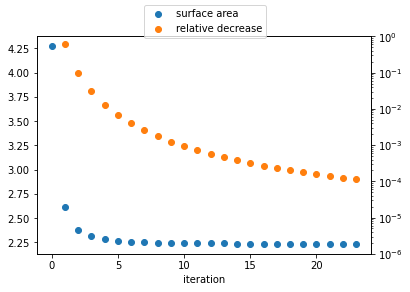

In [7]:
fig, axes = plt.subplots()
axes.scatter(list(range(num_iterations)), Js, label='surface area')
axes.set_xlabel('iteration')

axes = axes.twinx()
axes.scatter(list(range(1, num_iterations)), -np.diff(Js) / Js[1:],
             color='tab:orange', label='relative decrease')
axes.set_ylim(1e-6, 1)
axes.set_yscale('log')

fig.legend(loc='upper center');

This looks pretty good -- the iterates converge very rapidly to the minimizer.
There are still reasons to look for something better though.
Picard's method relies on the problem having special structure, which is true of the minimal surface equation but harder to find for other problems.

#### Newton's method (take 1)

One of the best known methods is due to Newton.
The idea behind Newton's method is to use the Taylor expansion of the objective at the current guess $u_{n - 1}$ up to second order to define a quadratic approximation to the objective:

$$J(u_n + v) = J(u_n) + \langle F, v\rangle + \frac{1}{2}\langle Hv, v\rangle + \ldots$$

where $F = dJ(u_n)$, $H = d^2J(u_n)$ are the first and second derivatives of the objective.
We can then define a new iterate as the minimizer of this quadratic problem:

$$u_{n + 1} = u_n + \text{argmin}_v\, \langle F, v\rangle + \frac{1}{2}\langle Hv, v\rangle.$$

The big advantage of Newton's method is that, for a starting guess sufficiently close to the solution, the iterates converge quadratically to the minimizer.
Picard's method converges at best linearly.

One of the advantages of Newton's method is that there are many software packages for automatically calculating first and second derivatives of nonlinear functionals.
So it's easy to apply to a broad class of problems.
It isn't quite so clear how to select the right linear operator for Picard's method.

In [8]:
u.interpolate(g)

F = firedrake.derivative(J, u)
H = firedrake.derivative(F, u)

v = firedrake.Function(Q)

num_iterations = 24
Js = np.zeros(num_iterations + 1)
Js[0] = firedrake.assemble(J)

bc = firedrake.DirichletBC(Q, 0, 'on_boundary')
params = {'ksp_type': 'cg', 'pc_type': 'icc'}
try:
    for step in range(1, num_iterations):
        firedrake.solve(H == -F, v, bc, solver_parameters=params)
        u += v
        Js[step] = firedrake.assemble(J)
except firedrake.ConvergenceError:
    print('Newton solver failed after {} steps!'.format(step))

Newton solver failed after 3 steps!


Doesn't bode very well does it?
Let's see what the objective functional did before exploding:

In [9]:
print(Js[:step])

[   4.27174587   13.03299587 2847.93224483]


Not a lot to save from the wreckage here -- the objective functional was increasing, which is just the opposite of what we want.
What happened?
Newton's method will converge quadratically *if initialized close enough to the true solution*.
We don't have any idea a priori if we're close enough, and if we aren't then there's no guarantee that the iterates will converge at all.
The example from Doug Arnold's course notes used a much smaller amplitude $a$ in the boundary data, so the initial guess is already within the convergence basin.

#### Newton's method (take 2)

But there's always hope!
Suppose $v$ is a function such that the directional derivative of $J$ at $u$ along $v$ is negative:

$$\langle dJ(u), v\rangle < 0.$$

Then there must be some sufficiently small real number $t$ such that

$$J(u + t\cdot v) < J(u).$$

If we do have a descent direction in hand, then the problem of finding a better guess $u_{n + 1}$ starting from $u_n$ is reduced to the one-dimensional problem to minimize $J(u_n + t\cdot v)$ with respect to the real variable $t$.

If $H$ is any symmetric, positive-definite linear operator, then

$$v = -H^{-1}dJ(u)$$

is a descent direction for $J$.
While the pure Newton method can diverge for some starting guesses, it does offer up a really good way to come up with descent directions for convex problems because the second derivative of the objective is positive-definite.
This suggests the following algorithm:

$$\begin{align}
v_n & = -d^2J(u_n)^{-1}dJ(u_n) \\
t_n & = \text{argmin}_t\, J(u_n + t\cdot v_n) \\
u_{n + 1} & = u_n + t_n\cdot v_n.
\end{align}$$

This is called the damped Newton method or the Newton line search method.
We can use standard packages like scipy to do the 1D minimization, as I'll show below.

In [10]:
u.interpolate(g)

F = firedrake.derivative(J, u)
H = firedrake.derivative(F, u)

v = firedrake.Function(Q)
bc = firedrake.DirichletBC(Q, 0, 'on_boundary')

import scipy.optimize
t = firedrake.Constant(1)
def J_t(s):
    t.assign(s)
    return firedrake.assemble(firedrake.replace(J, {u: u + t * v}))

num_iterations = 24
Js = np.zeros(num_iterations)
ts = np.zeros(num_iterations)
Δs = np.zeros(num_iterations)
Js[0] = firedrake.assemble(J)

from firedrake import action
for step in range(1, num_iterations):
    firedrake.solve(H == -F, v, bc, solver_parameters=params)
    Δs[step] = firedrake.assemble(-action(F, v))
    
    line_search_result = scipy.optimize.minimize_scalar(J_t)
    if not line_search_result.success:
        raise firedrake.ConvergenceError('Line search failed at step {}!'
                                         .format(step))
    t_min = firedrake.Constant(line_search_result.x)
    u.assign(u + t_min * v)

    ts[step] = t_min
    Js[step] = firedrake.assemble(J)

The same convergence plot as above for Newton's method paints a very different picture.

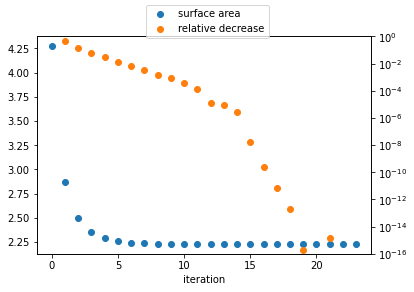

In [11]:
fig, axes = plt.subplots()
axes.scatter(list(range(num_iterations)), Js, label='surface area')
axes.set_xlabel('iteration')

axes = axes.twinx()
axes.scatter(list(range(1, num_iterations)), -np.diff(Js) / Js[1:],
             color='tab:orange', label='relative decrease')
axes.set_ylim(1e-16, 1)
axes.set_yscale('log')

fig.legend(loc='upper center');

The algorithm starts converges linearly just like the Picard method does.
The second phase starts around iteration 15.
By this point, the algorithm has entered the quadratic convergence basin and the errors plummet.

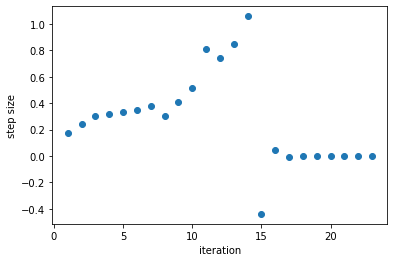

In [12]:
fig, axes = plt.subplots()
axes.scatter(list(range(1, num_iterations)), ts[1:])
axes.set_xlabel('iteration')
axes.set_ylabel('step size');

Another revealing way to look at this is to examine the *Newton decrement*.
The Newton decrement $\Delta_k$ at step $k$ is defined as the directional derivative of the objective functional along the search direction:

$$\Delta_k = \langle dJ(u_k), v_k\rangle.$$

The Newton decrement is approximately half of the difference between the value of the objective at the current guess and the next guess:

$$\begin{align}
J(u_{k + 1}) - J(u_k) & = \langle dJ(u_k), v_k\rangle + \frac{1}{2}\langle d^2J(u_k)v_k, v_k\rangle + \ldots \\
& = \langle dJ(u_k), v_k\rangle - \frac{1}{2}\langle dJ(u_k), v_k\rangle + \ldots\\
& = \frac{1}{2}\langle dJ(u_k), v_k\rangle + \ldots
\end{align}$$

where we have used the fact that $v_k = -d^2J(u_k)^{-1}dJ(u_k)$ in going from the first line to the second.
An informal way of describing the Newton decrement is that it gives an upper bound on how much we can expect reduce the objective functional by one more iteration of Newton's method.

The plot below shows the ratio of the differences in the objective functional to the value of the Newton decrement.

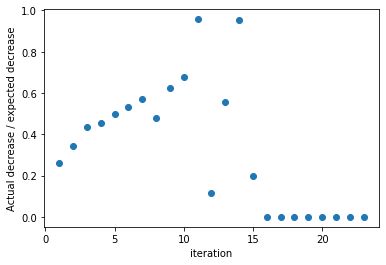

In [13]:
fig, axes = plt.subplots()
axes.scatter(list(range(1, num_iterations)), -2 * np.diff(Js) / Δs[1:])
axes.set_xlabel('iteration')
axes.set_ylabel('Actual decrease / expected decrease');

During the first few iterations while the method is iterating towards the quadratic convergence basin, the Newton decrement is less than half of the actual decrease.
Once the method has found the convergence basin the ratio hits almost exactly 1/2 at a few points.
Finally, once the method has effectively converged, the ratio drops to 0.

In the code above, I picked a fixed value of the iteration count.
For real applications it's better to have a dynamic stopping criterion based on the current and past state.
The Newton decrement is a useful quantity in this respect because it depends only on the current state.
Here we'll plot the ratio of the Newton decrement to the value of the objective itself.

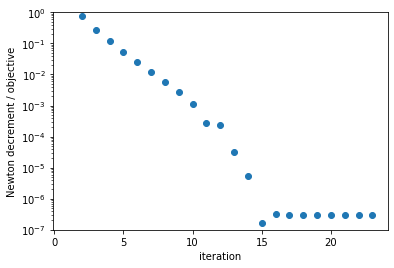

In [14]:
fig, axes = plt.subplots()
axes.scatter(list(range(1, num_iterations)), Δs[1:] / Js[:-1])
axes.set_ylim(1e-7, 1)
axes.set_yscale('log')
axes.set_xlabel('iteration')
axes.set_ylabel('Newton decrement / objective');

A sensible stopping criterion is that $\Delta_k < \epsilon \cdot J(u_k)$ where the tolerance $\epsilon$ is about $10^{-6}$.
It's handy to think about this in terms of the informal description of the Newton decrement -- stop iterating when the expected gain is less than some small fraction of the currrent cost.

For the minimal surface equation, the objective functional is strictly positive and convex.
Other problems might be convex but the objective is a sum of parts that can be either positive or negative.
For example, for viscous flow problems, the objective can be divided into internal viscous dissipation of energy (strictly positive) and the power from driving stress (positive or negative).
For more general problems it would then be incumbent on you as the modeler to know in advance which parts of the objective are strictly positive and use these to set the scale in the convergence criterion.

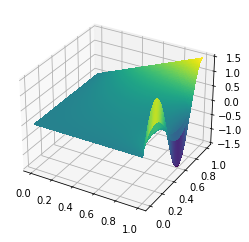

In [15]:
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
firedrake.trisurf(u, axes=axes);